# paftdunk

Let's create some fake data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs

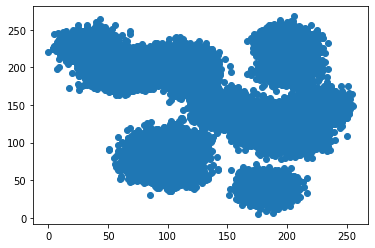

In [165]:
X, y = make_blobs(n_samples = 50000, centers=20)
X = np.round(X*10)
X += np.abs(np.min(X))
plt.scatter(X[:, 0], X[:, 1])

Possible hyperparams; 

- min overlap rows
- min user occurence
- min item occurence


In [166]:
min_overlap = 5
min_item_occ = 5
min_user_occ = 5
smoothing = 10
# costfunc + alpha, beta, gamma

def window(seq):
    for idx in range(len(seq) - 1):
        yield seq[idx], seq[idx+1]
        yield seq[idx + 1], seq[idx]

def start_pipeline(dataf):
    return dataf.copy()

def remove_outliers(dataf, min_items_per_user=0, min_users_per_item=0):
    user_df = calc_user_activity(dataf)
    item_df = calc_item_activity(dataf)
    bad_users = user_df.loc[lambda d: d['n_uniq_item'] < min_items_per_user].user_id
    bad_items = item_df.loc[lambda d: d['n_uniq_user'] < min_users_per_item].item_id
    return (dataf
             .loc[lambda d: ~d['user_id'].isin(bad_users)]
             .loc[lambda d: ~d['item_id'].isin(bad_items)])

def calc_overlap_df(dataf):
    agg_df = dataf.groupby('user_id').apply(lambda d: list(d['item_id']))
    chain_of_window = chain(*(list(window(i[1])) for i in agg_df.items()))
    return (pd.DataFrame(chain_of_window, columns=['item_from', 'item_id'])
              .assign(n=1)
              .groupby(['item_from', 'item_id'])
              .agg(n_overlap=('n', 'count'))
              .reset_index())

def calc_usertitem(dataf):
    pass

def calc_itemuser(dataf):
    pass

def calc_useruser(dataf):
    pass

def calc_itemitem(dataf, min_overlap=5):
    item_df = calc_item_activity(dataf)
    n_user = df.user_id.nunique()
    return (dataf 
             .pipe(calc_overlap_df)
             .loc[lambda d: d['n_overlap'] >= min_overlap]
             .set_index('item_id')
             .join(item_df.set_index('item_id'))
             .reset_index()
             .rename(columns={'item_id': 'item_to', 
                              'item_from': 'item_id', 
                              'n_uniq_user': 'n_uniq_to'})
             .set_index('item_id')
             .join(item_df.set_index('item_id'))
             .reset_index()
             .rename(columns={'item_id': 'item_from', 
                              'n_uniq_user': 'n_uniq_from'})
             .assign(n_total_user=n_user))

def calc_user_activity(dataf):
    return (dataf
               .groupby('user_id')
               .agg(n_uniq_item=('item_id', 'nunique'))
               .reset_index())

def calc_item_activity(dataf):
    return (dataf
               .groupby('item_id')
               .agg(n_uniq_user=('user_id', 'nunique'))
               .reset_index())

In [171]:
df = pd.DataFrame(X, columns=['user_id', 'item_id']).astype(int)
rec_df = (df
 .pipe(remove_outliers, min_items_per_user=5, min_users_per_item=5)
 .pipe(calc_itemitem, min_overlap=1)
 .assign(rating=lambda d: (d['n_overlap']/d['n_uniq_from'])/(d['n_uniq_to']/d['n_total_user'])))

rec_df.head()

,item_from,item_to,n_overlap,n_uniq_to,n_uniq_from,n_total_user,rating
0,16,19,1,12,8,253,0.125
1,16,33,1,37,8,253,0.125
2,16,34,1,35,8,253,0.125
3,16,54,1,59,8,253,0.125
4,16,107,1,102,8,253,0.125


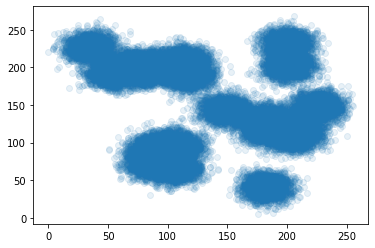

In [172]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)

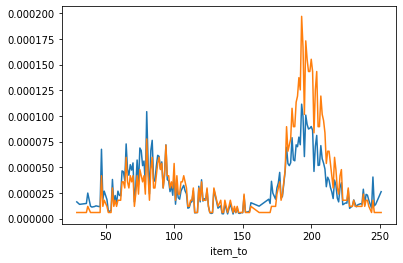

In [181]:
item_to_rec = 200

rec_df = (df
 .pipe(remove_outliers, min_items_per_user=5, min_users_per_item=5)
 .pipe(calc_itemitem, min_overlap=1)
 .assign(rating=lambda d: (d['n_overlap']/d['n_uniq_from'])/(d['n_uniq_to']/d['n_total_user']))
 .assign(rating=lambda d: d['rating']/d['rating'].sum()))

resdf = rec_df.loc[lambda d: d['item_from'] == item_to_rec]
resdf.sort_values('item_to').set_index('item_to')['rating'].plot()

rec_df = (df
 .pipe(remove_outliers, min_items_per_user=5, min_users_per_item=5)
 .pipe(calc_itemitem, min_overlap=1)
 .assign(rating=lambda d: (d['n_overlap']/d['n_uniq_from']))
 .assign(rating=lambda d: d['rating']/d['rating'].sum()))

resdf = rec_df.loc[lambda d: d['item_from'] == item_to_rec]
resdf.sort_values('item_to').set_index('item_to')['rating'].plot()

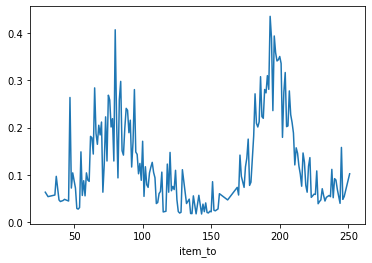

In [170]:
item_to_rec = 200
resdf = rec_df.loc[lambda d: d['item_from'] == item_to_rec]
resdf.sort_values('item_to').set_index('item_to')['rating'].plot()